In [3]:
import pandas as pd
import sklearn
import numpy as np

In [27]:
df = pd.read_csv("../Binance/btcusdt.csv")
df

,Unnamed: 0,Open,Close,High,Low
0,0,739,736,739,736
1,1,736,742,742,736
2,2,742,736,742,736
3,3,736,733,736,733
4,4,733,730,733,730
...,...,...,...,...,...
323743,323743,1522,1528,1528,1522
323744,323744,1528,1531,1531,1528
323745,323745,1531,1534,1534,1531
323746,323746,1534,1528,1534,1528


In [28]:
# #Check if any zero volumes are available
# # indexZeros = df[ df['Volume'] == 0 ].index

# df.drop(indexZeros , inplace=True)
# df.loc[(df["Volume"] == 0 )]
# df.isna().sum()

In [29]:
df.head()

,Unnamed: 0,Open,Close,High,Low
0,0,739,736,739,736
1,1,736,742,742,736
2,2,742,736,742,736
3,3,736,733,736,733
4,4,733,730,733,730


In [30]:
import pandas_ta as ta

In [31]:
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['EMA55'] = df.ta.ema(length=55)
df['EMA21'] = df.ta.ema(length=21)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [32]:
backrollingN = 6

In [33]:
df['slopeRSI'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeEMA55'] = df['EMA55'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeEMA21'] = df['EMA21'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [34]:
df = df.dropna()

In [35]:
df

,Unnamed: 0,Open,Close,High,Low,ATR,RSI,EMA55,EMA21,slopeRSI,slopeEMA55,slopeEMA21
59,59,778,775,778,775,4.287453,55.349412,751.673683,771.737521,-1.322101,1.100499,0.898507
60,60,775,772,775,772,4.223080,52.605717,752.399623,771.761382,-1.619906,1.021399,0.715526
61,61,772,769,772,769,4.161926,49.939755,752.992493,771.510348,-2.859986,0.883900,0.393335
62,62,769,766,769,766,4.103830,47.355270,753.457047,771.009407,-3.195386,0.729884,0.045889
63,63,766,763,766,763,4.048638,44.855347,753.797867,770.281279,-2.662967,0.596674,-0.231010
...,...,...,...,...,...,...,...,...,...,...,...,...
323743,323743,1522,1528,1528,1522,3.822366,51.937356,1527.856983,1525.545370,1.507346,-0.108154,-0.037426
323744,323744,1528,1531,1531,1528,3.781248,54.632721,1527.969233,1526.041246,1.378896,-0.055311,0.090652
323745,323745,1531,1534,1534,1531,3.742186,57.216588,1528.184618,1526.764769,1.591601,0.007889,0.238255
323746,323746,1534,1528,1534,1528,3.855076,50.964696,1528.178024,1526.877062,0.898186,0.047403,0.317894


In [48]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 0 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 1 # uptrend
                break
#             else:
#                 trendcat[line] = 0 # no clear trend
            
    return trendcat

In [49]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

C:\Users\hites\AppData\Local\Temp/ipykernel_10292/1455277383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mytarget'] = mytarget(16, df)


,Unnamed: 0,Open,Close,High,Low,ATR,RSI,EMA55,EMA21,slopeRSI,slopeEMA55,slopeEMA21,mytarget
59,59,778,775,778,775,4.287453,55.349412,751.673683,771.737521,-1.322101,1.100499,0.898507,0.0
60,60,775,772,775,772,4.223080,52.605717,752.399623,771.761382,-1.619906,1.021399,0.715526,0.0
61,61,772,769,772,769,4.161926,49.939755,752.992493,771.510348,-2.859986,0.883900,0.393335,0.0
62,62,769,766,769,766,4.103830,47.355270,753.457047,771.009407,-3.195386,0.729884,0.045889,0.0
63,63,766,763,766,763,4.048638,44.855347,753.797867,770.281279,-2.662967,0.596674,-0.231010,0.0


In [50]:
df = df.dropna()
attributes = ['ATR', 'RSI', 'EMA55', 'EMA21', 'slopeRSI', 'slopeEMA55', 'slopeEMA21']
x = df[attributes]
y = df['mytarget']
print(x)

             ATR        RSI        EMA55        EMA21  slopeRSI  slopeEMA55  \
59      4.287453  55.349412   751.673683   771.737521 -1.322101    1.100499   
60      4.223080  52.605717   752.399623   771.761382 -1.619906    1.021399   
61      4.161926  49.939755   752.992493   771.510348 -2.859986    0.883900   
62      4.103830  47.355270   753.457047   771.009407 -3.195386    0.729884   
63      4.048638  44.855347   753.797867   770.281279 -2.662967    0.596674   
...          ...        ...          ...          ...       ...         ...   
323707  3.740855  32.156543  1530.224926  1521.429436  0.089294   -0.686195   
323708  3.853812  39.567895  1529.609750  1520.663124 -0.411194   -0.716790   
323709  3.811122  42.925184  1529.123687  1520.239203  0.571673   -0.709557   
323710  3.770566  46.147103  1528.762127  1520.126548  2.400330   -0.629114   
323711  3.732037  49.233368  1528.520622  1520.296862  3.457298   -0.505625   

        slopeEMA21  
59        0.898507  
60       

In [51]:
df.isna().sum()

Unnamed: 0    0
Open          0
Close         0
High          0
Low           0
ATR           0
RSI           0
EMA55         0
EMA21         0
slopeRSI      0
slopeEMA55    0
slopeEMA21    0
mytarget      0
dtype: int64

In [52]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=2)

In [53]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=100 , weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(xtrain, ytrain)

y_pred_train = model.predict(xtrain)
y_pred_test = model.predict(xtest)

C:\Users\hites\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hites\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [54]:
from sklearn.metrics import accuracy_score
accurancy_train = accuracy_score(ytrain, y_pred_train)
accuracy_tesst = accuracy_score(ytest, y_pred_test)

print("accuracy train %.f%% "% (accurancy_train*100))
print("accuracy test %.f%% "% (accuracy_tesst*100))

accuracy train 68% 
accuracy test 67% 


In [55]:
print(df['mytarget'].value_counts()*100/df['mytarget'].count())


pred_test = np.random.choice([0,1,2], len(y_pred_test))
accuracy_tesst = accuracy_score(ytest, pred_test)
print("accuracy gambler %.2f%%" %(accuracy_tesst*100))

1.0    50.038467
0.0    49.961533
Name: mytarget, dtype: float64
accuracy gambler 33.31%


In [56]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(xtrain, ytrain)
pred_train = model.predict(xtrain,)
pred_test = model.predict(xtest)

acc_train = accuracy_score(ytrain, pred_train)
acc_test = accuracy_score(ytest, pred_test)


print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 77.6531%
****Test Results****
Accuracy: 77.4884%


In [57]:
# Data Smaples Shouldn't be random , it must be in perfecct sequence 
train_index = int(0.8 * len(x))
xtrain, xtest = x[:train_index], x[train_index:]
ytrain, ytest = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(xtrain, ytrain)
pred_train = model.predict(xtrain)
pred_test = model.predict(xtest)
acc_train = accuracy_score(ytrain, pred_train)
acc_test = accuracy_score(ytest, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 78.5360%
****Test Results****
Accuracy: 73.8317%


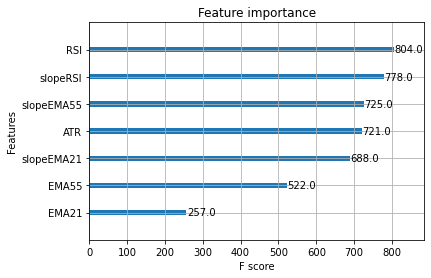

In [58]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

In [63]:
from sklearn.metrics import confusion_matrix
import pandas as pd



# Create the contingency mat
matrix = confusion_matrix(ytest, pred_test)

# Convert the matrix to a DataFrame for easy display
matrix_df = pd.DataFrame(matrix, columns=[ 'pred_Downtrend','pred_Uptrend'], index=[ 'Downtrend','Uptrend'])

print(matrix_df)


           pred_Downtrend  pred_Uptrend
Downtrend           24087          8501
Uptrend              8438         23705


In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd



# Create the contingency mat
matrix_test = confusion_matrix(ytest, pred_test)
matrix_train = confusion_matrix(ytrain, pred_train)
classification_report_pred = classification_report(ytest, y_pred_test, target_names=["downtrend", "uptrend"])

# Convert the matrix to a DataFrame for easy display

matrix_df_test = pd.DataFrame(matrix_test, columns=['pred_Downtrend','pred_Uptrend'], index=['Downtrend','Uptrend'])
# matrix_df_test = pd.DataFrame(matrix_test, columns=['pred_sideways','pred_Downtrend','pred_Uptrend'], index=['Sidetrend','Downtrend','Uptrend'])

matrix_df_train = pd.DataFrame(matrix_train, columns=['pred_Downtrend','pred_Uptrend'], index=['Downtrend','Uptrend'])
# matrix_df_train = pd.DataFrame(matrix_train, columns=['pred_sideways','pred_Downtrend','pred_Uptrend'], index=['Sidetrend','Downtrend','Uptrend'])
print("Test-Set Confusion Matrix\n")
print(matrix_df_test)
print("-----------------------------------------------------------------------------")
print("Train-Set Confusion Matrix\n")
print(matrix_df_train)
print("-----------------------------------------------------------------------------")
print("Classification Report\n")
print(classification_report_pred)

Test-Set Confusion Matrix

           pred_Downtrend  pred_Uptrend
Downtrend           24087          8501
Uptrend              8438         23705
-----------------------------------------------------------------------------
Train-Set Confusion Matrix

           pred_Downtrend  pred_Uptrend
Downtrend          101276         27838
Uptrend             27737        102071
-----------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

   downtrend       0.50      0.50      0.50     32588
     uptrend       0.49      0.49      0.49     32143

    accuracy                           0.50     64731
   macro avg       0.50      0.50      0.50     64731
weighted avg       0.50      0.50      0.50     64731

